# [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

### [10% 範例](https://jackdry.com/house-prices-advanced-regression-techniques-kaggle)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.model_selection # 分割資料模組
import sklearn.linear_model # 線性模組
import sklearn.svm # SVM 模組
import sklearn.decomposition # PCA

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv', index_col='Id') # train datas
test = pd.read_csv('test.csv', index_col='Id') # test datas
submission = pd.read_csv('sample_submission.csv') # 上傳範本

In [3]:
def fig_price_x(column):
    try:
        print(column)
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.grid()
        filter_ = train[column].notnull()
        ax.scatter(train[column][filter_], train["SalePrice"][filter_], c="#3f72af", zorder=3, alpha=0.9)
        plt.show()
    except:
        print('error')

GrLivArea


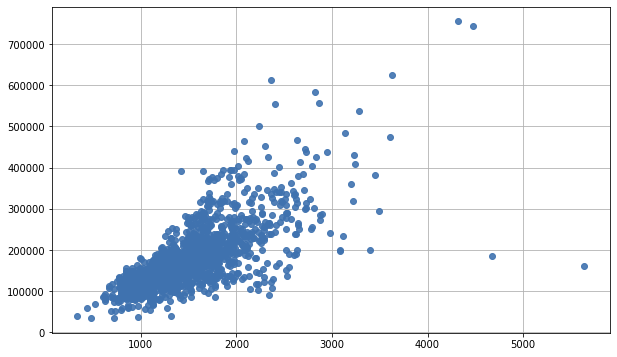

In [4]:
fig_price_x('GrLivArea')

### 去掉極值

GrLivArea


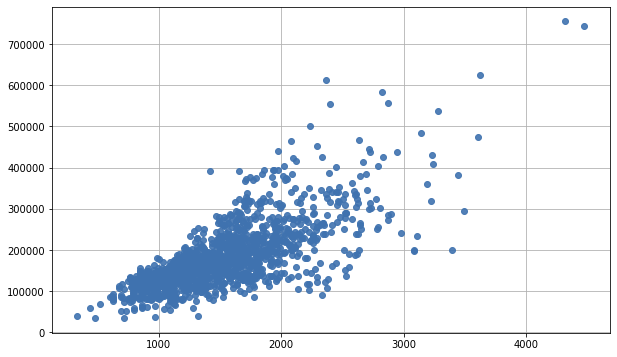

In [5]:
train = train[train["GrLivArea"] < 4500]
fig_price_x('GrLivArea')

### 分出訓練資料 房屋價格取log

In [6]:
X = pd.concat([train.drop("SalePrice", axis=1), test])
y_train = np.log(train["SalePrice"])

### 檢查空值

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
Exterior1st        1
SaleType           1
Electrical         1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64


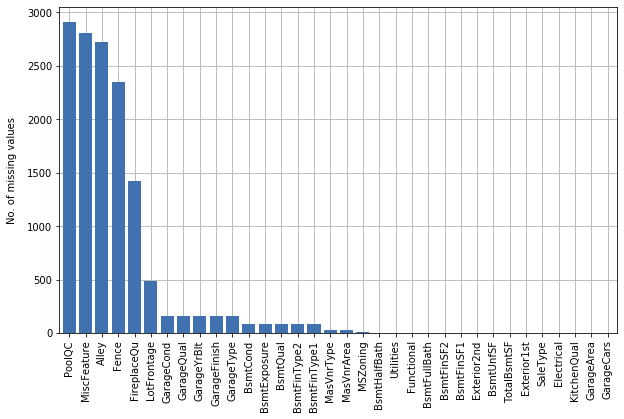

In [7]:
nans = X.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
print(nans)

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.bar(nans.index, nans.values, zorder=2, color="#3f72af")
ax.set_ylabel("No. of missing values", labelpad=10)
ax.set_xlim(-0.6, len(nans) - 0.4)
ax.xaxis.set_tick_params(rotation=90)

### 空值補值

In [8]:
cols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageCond", "GarageQual", "GarageFinish", "GarageType", "BsmtCond", "BsmtExposure", "BsmtQual", "BsmtFinType2", "BsmtFinType1"]
X[cols] = X[cols].fillna("None")
cols = ["GarageYrBlt", "MasVnrArea", "BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "GarageCars"]
X[cols] = X[cols].fillna(0)
cols = ["MasVnrType", "MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "KitchenQual", "Functional"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))
cols = ["GarageArea", "LotFrontage"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.median()))

### Engineer features 追加一點特徵

In [9]:
X["TotalSF"] = X["GrLivArea"] + X["TotalBsmtSF"]
X["TotalPorchSF"] = X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"]
X["TotalBath"] = X["FullBath"] + X["BsmtFullBath"] + 0.5 * (X["BsmtHalfBath"] + X["HalfBath"])

### 把一些特徵改成分類形式

In [10]:
cols = ["MSSubClass", "YrSold"]
X[cols] = X[cols].astype("category")

### Transform features
* 循環的資料投影到兩維中的圓形中(1~12月)

In [11]:
X["SinMoSold"] = np.sin(2 * np.pi * X["MoSold"] / 12)
X["CosMoSold"] = np.cos(2 * np.pi * X["MoSold"] / 12)
X = X.drop("MoSold", axis=1)

### 資料偏度過大調正 [Box-Cox Transformation](https://blog.minitab.com/blog/applying-statistics-in-quality-projects/how-could-you-benefit-from-a-box-cox-transformation)
* [`pandas.DataFrame.skew`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.skew.html)
* 偏度公式： $skew(X)=E[(\frac{X-\mu}{\sigma})^3]$
* box-cox轉換：
    * [`scipy.special.boxcox(x, 𝜆)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.boxcox.html)
    * [`scipy.special.boxcox1p(x, 𝜆)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.boxcox1p.html) (有+1, 避免出現 0)
    * $Y(x) = (x^{\lambda} - 1)/\lambda$
* $\lambda$ 的選擇：
    * [`scipy.stats.boxcox_normmax(x)`](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.boxcox_normmax.html) 計算最佳的 $\lambda$

In [12]:
X.skew(numeric_only=True)

LotFrontage       1.103606
LotArea          13.116240
OverallQual       0.189688
OverallCond       0.569607
YearBuilt        -0.599503
YearRemodAdd     -0.450365
MasVnrArea        2.623068
BsmtFinSF1        0.981149
BsmtFinSF2        4.146636
BsmtUnfSF         0.920161
TotalBsmtSF       0.672097
1stFlrSF          1.257933
2ndFlrSF          0.861999
LowQualFinSF     12.090757
GrLivArea         1.069300
BsmtFullBath      0.622735
BsmtHalfBath      3.932018
FullBath          0.165599
HalfBath          0.697024
BedroomAbvGr      0.326736
KitchenAbvGr      4.302763
TotRmsAbvGrd      0.749618
Fireplaces        0.725651
GarageYrBlt      -3.906642
GarageCars       -0.219410
GarageArea        0.219485
WoodDeckSF        1.845741
OpenPorchSF       2.530660
EnclosedPorch     4.004404
3SsnPorch        11.377932
ScreenPorch       3.947131
PoolArea         17.697766
MiscVal          21.950962
TotalSF           1.012326
TotalPorchSF      2.245655
TotalBath         0.486693
SinMoSold         0.014387
C

In [13]:
skew = X.skew(numeric_only=True).abs()
cols = skew[skew > 1].index

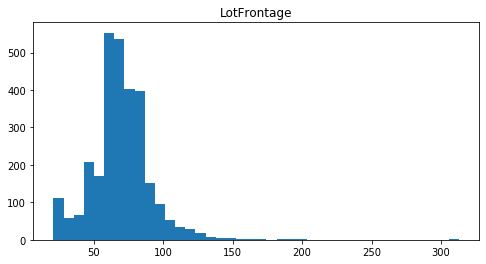

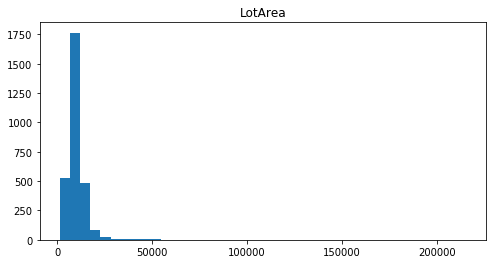

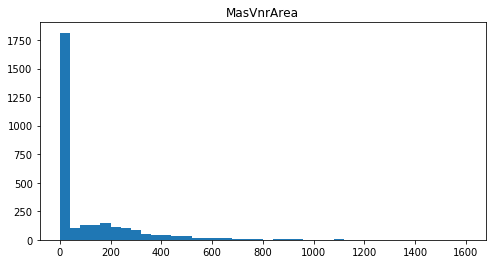

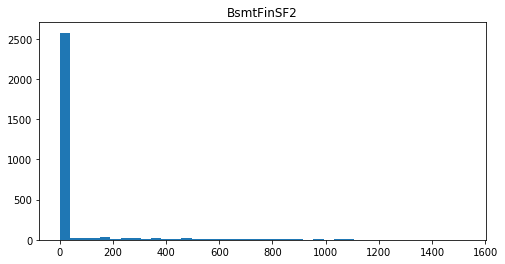

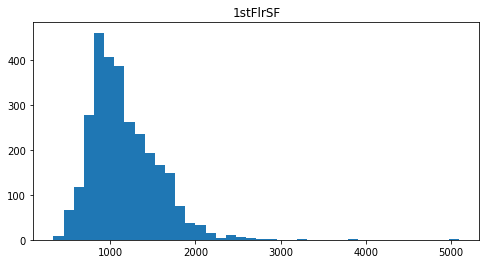

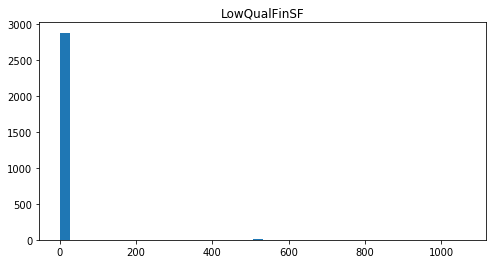

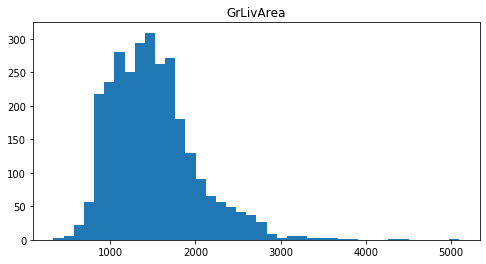

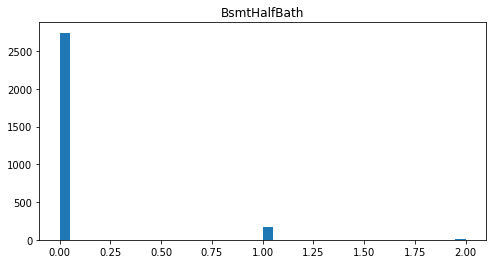

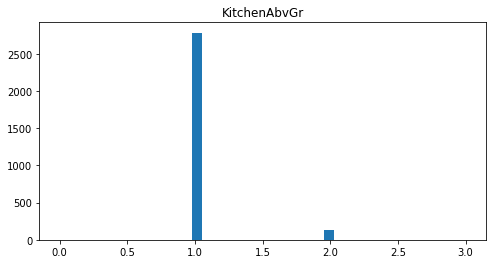

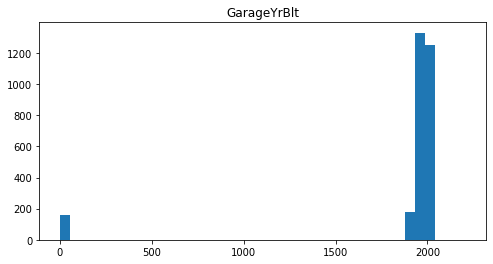

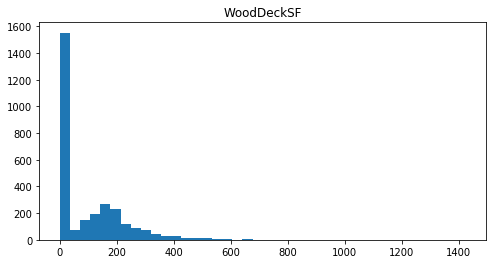

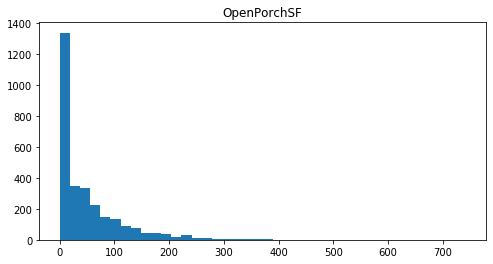

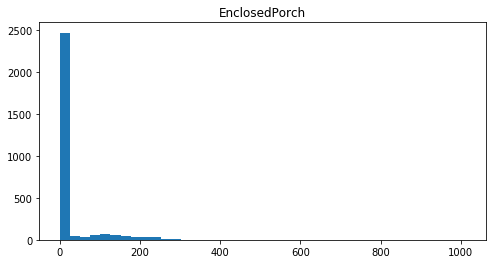

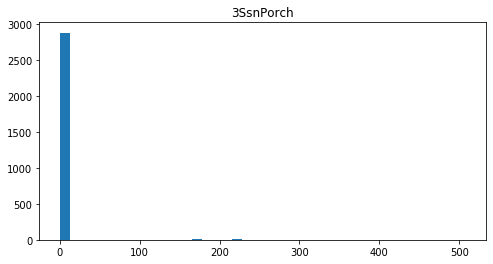

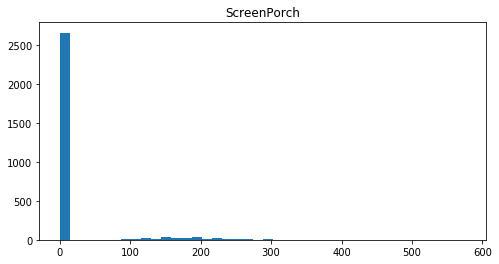

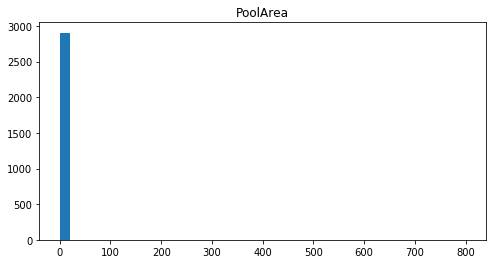

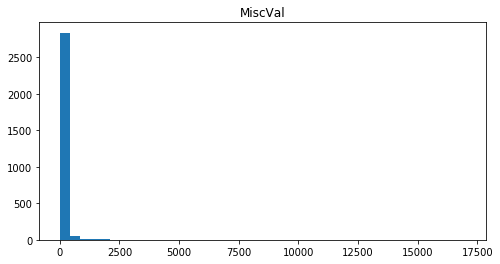

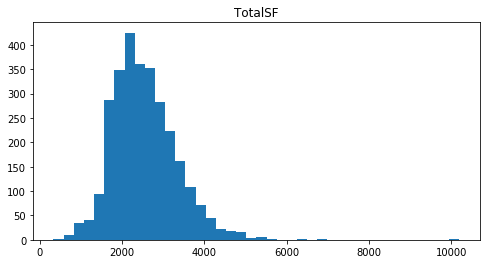

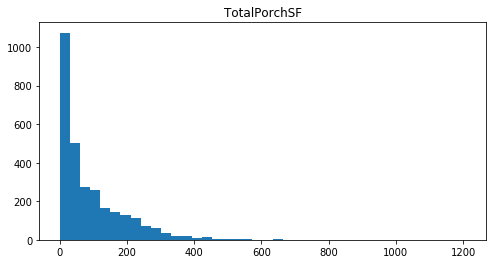

In [14]:
for col in cols:
    plt.figure(figsize=(8, 4))
    plt.hist(X[col], bins=40)
    plt.title(col)
    plt.show()

In [15]:
for col in cols:
    X[col] = scipy.special.boxcox1p(X[col], scipy.stats.boxcox_normmax(X[col] + 1))

/home/sppool/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/sppool/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


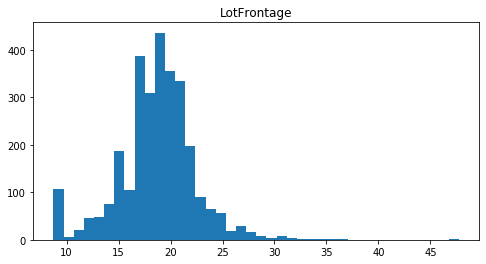

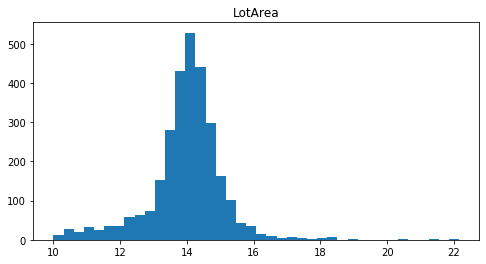

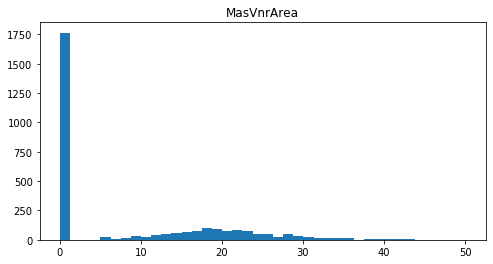

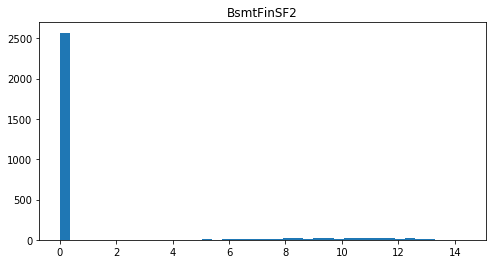

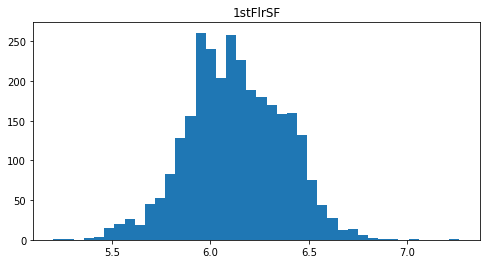

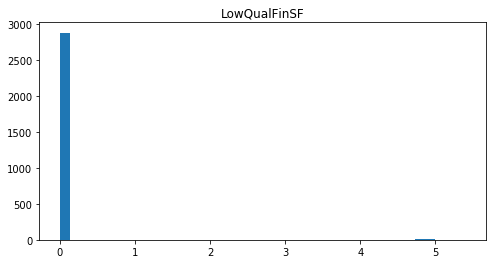

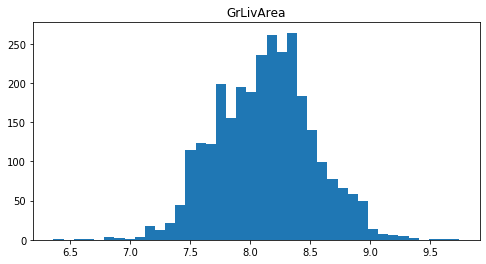

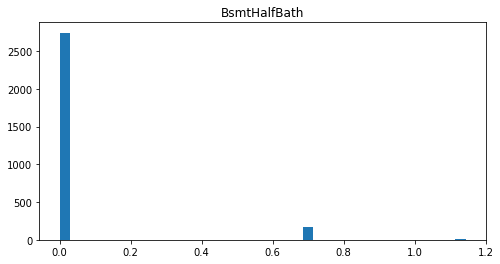

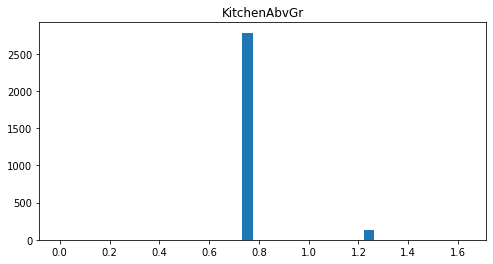

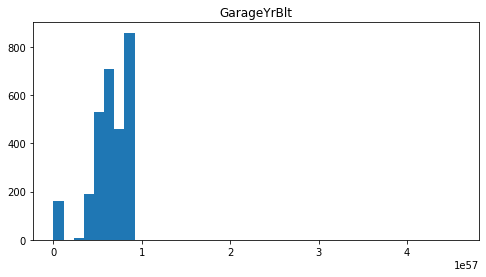

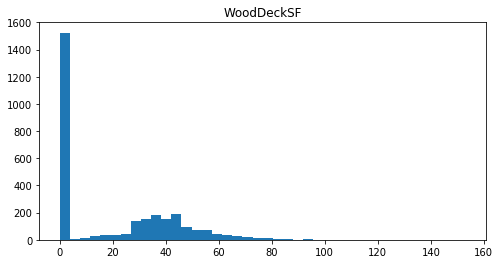

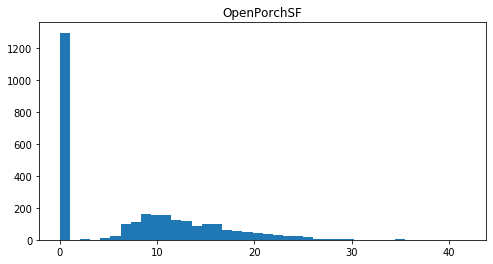

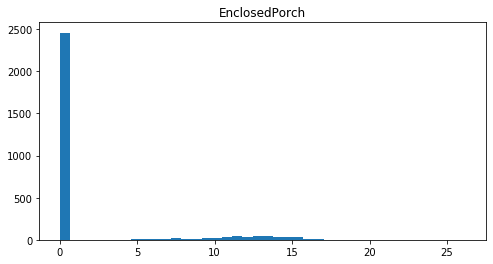

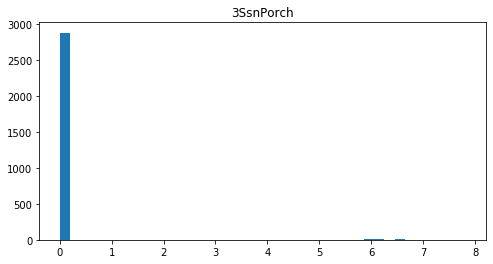

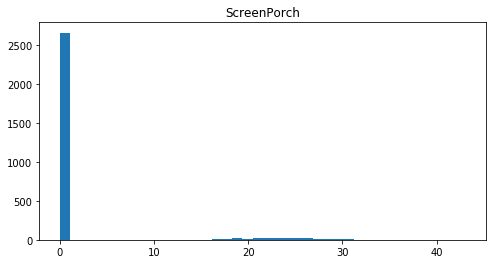

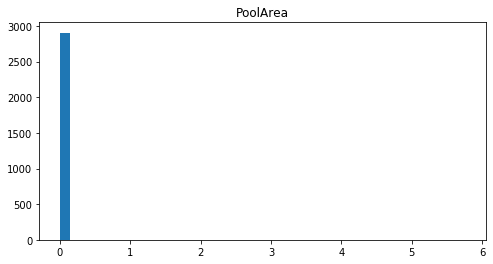

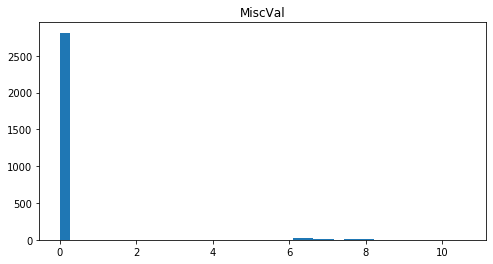

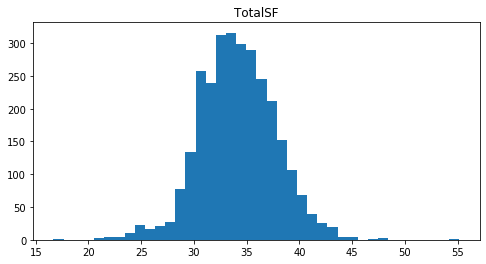

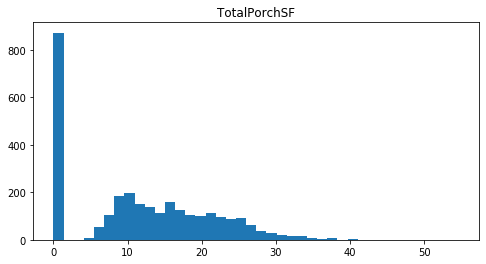

In [16]:
for col in cols:
    plt.figure(figsize=(8, 4))
    plt.hist(X[col], bins=40)
    plt.title(col)
    plt.show()

### 把數值形式的column 做正規化

In [17]:
cols = X.select_dtypes(np.number).columns
X[cols] = sklearn.preprocessing.RobustScaler().fit_transform(X[cols])

### 非數值的用one-hot編碼

In [18]:
X = pd.get_dummies(X)

### Recover training and test features

In [19]:
X_train = X.loc[train.index]
X_test = X.loc[test.index]

In [20]:
X

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.253280,-0.256404,0.5,0.0,0.625000,0.256410,1.090493,0.461119,0.0,-0.542808,...,0,0,0,1,0,0,0,0,1,0
2,0.485350,0.035750,0.0,3.0,0.062500,-0.435897,0.000000,0.832196,0.0,-0.313356,...,0,0,0,1,0,0,0,0,1,0
3,-0.100395,0.403523,0.5,0.0,0.583333,0.230769,0.997099,0.160982,0.0,-0.056507,...,0,0,0,1,0,0,0,0,1,0
4,-0.514650,0.023729,0.5,0.0,-1.208333,-0.589744,0.000000,-0.207367,0.0,0.125000,...,0,0,0,1,1,0,0,0,0,0
5,0.672460,0.962980,1.0,0.0,0.562500,0.179487,1.425556,0.391542,0.0,0.039384,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,-3.003962,-3.402038,-1.0,2.0,-0.062500,-0.589744,0.000000,-0.502046,0.0,0.135274,...,0,0,0,1,0,0,0,0,1,0
2916,-3.003962,-3.445829,-1.0,0.0,-0.062500,-0.589744,0.000000,-0.158254,0.0,-0.296233,...,0,0,0,1,1,0,0,0,0,0
2917,3.721865,1.781744,-0.5,2.0,-0.270833,0.076923,0.000000,1.167804,0.0,-0.799658,...,0,0,0,1,1,0,0,0,0,0


### 把預測太扯的數值給抓出來刪除
* [`scipy.stats.zscore(x)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html)
* `sklearn.preprocessing.scale(x)` 相同功用

In [21]:
residuals = y_train - sklearn.linear_model.LinearRegression().fit(X_train, y_train).predict(X_train)
outliers = residuals[np.abs(scipy.stats.zscore(residuals)) > 3].index

In [22]:
X_train = X_train.drop(outliers)
y_train = y_train.drop(outliers)

### 以下不懂
* `func = lambda x1, x2, ... : 運算式`
* `sklearn.metrics.mean_squared_error(X ,Y)` : `((X - Y)**2).mean()`
* [`sklearn.metrics.make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html)

In [23]:
kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True)
rmse = lambda y, y_pred: sklearn.metrics.mean_squared_error(y, y_pred)**0.5

scorer = sklearn.metrics.make_scorer(rmse, greater_is_better=False)

In [25]:
from multiprocessing import cpu_count

def random_search(model, grid, n_iter=100):
    n_jobs = max(cpu_count(), 1)
    search = sklearn.model_selection.RandomizedSearchCV(model, grid, n_iter, scorer, n_jobs=n_jobs, cv=kf, random_state=0, verbose=True)
    return search.fit(X_train, y_train)

In [26]:
ridge_search = random_search(sklearn.linear_model.Ridge(), {"alpha": np.logspace(-1, 2, 500)})
lasso_search = random_search(sklearn.linear_model.Lasso(), {"alpha": np.logspace(-5, -1, 500)})
svr_search = random_search(sklearn.svm.SVR(), {"C": np.arange(1, 101, 10), "gamma": np.linspace(0.00001, 0.001, 100), "epsilon": np.linspace(0.01, 0.1, 10)})

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    3.6s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 292 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   29.6s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished


In [27]:
models = [search.best_estimator_ for search in [ridge_search, lasso_search, svr_search]]

In [28]:
arr = 0
for model in models:
    arr += model.predict(X_test)
arr /= len(models)

In [29]:
submission = pd.read_csv('sample_submission.csv') # 上傳範本
submission.SalePrice = np.exp(arr)
submission.to_csv('submission.csv', index=0)

# 0.11683